In [1]:
import torch
from utils.dataloader import get_dataloaders
from utils.train import train_model, test_model
from utils.metrics import (
    plot_history,
    plot_confusion_matrix,
    save_results_csv,
    plot_model_comparison,
)

from models.single_models import get_single_model
from models.hybrid_models import get_hybrid_model, get_multi_hybrid_model

C:\Users\navne\anaconda3\envs\lung_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:",device)

Using device: cuda


In [3]:
DATA_DIR = "lung_ct_split"

preprocess_cfg = {
    "windowing": False,
    "clahe": True,
    "hist_eq": False,
    "gaussian": True,
    "median": False,
    "sharpen_flag": False,
    "norm_type": "minmax"
}

train_loader, val_loader, test_loader, class_names = get_dataloaders(
    data_dir = DATA_DIR,
    batch_size = 16,
    preprocess_config= preprocess_cfg,
)

print("Classes: ",class_names)

Classes:  ['Bengin cases', 'Malignant cases', 'Normal cases']


In [4]:
from PIL import Image
import os

bad_files = []

for root, _, files in os.walk(DATA_DIR):
    for f in files:
        path = os.path.join(root, f)
        try:
            Image.open(path).verify()
        except:
            bad_files.append(path)

print("Corrupted images:", len(bad_files))
bad_files[:10]

Corrupted images: 0


[]

In [21]:
EPOCHS = 15

single_model_names = [
    "resnet50",
    # "vgg16",
    # "efficientnet",
    # "inception",
    "vit",
]

results = {}
histories = {}


===== Training VIT =====

Epoch 1/15
Train Loss: 0.6391 | Train Acc: 0.7353
Val   Loss: 1.0388 | Val   Acc: 0.6402

Epoch 2/15
Train Loss: 0.3862 | Train Acc: 0.8540
Val   Loss: 2.2778 | Val   Acc: 0.5427

Epoch 3/15
Train Loss: 0.3688 | Train Acc: 0.8657
Val   Loss: 0.7305 | Val   Acc: 0.7805

Epoch 4/15
Train Loss: 0.2784 | Train Acc: 0.9061
Val   Loss: 0.5501 | Val   Acc: 0.7927

Epoch 5/15
Train Loss: 0.2523 | Train Acc: 0.9126
Val   Loss: 0.2039 | Val   Acc: 0.9268

Epoch 6/15
Train Loss: 0.2497 | Train Acc: 0.9022
Val   Loss: 0.2797 | Val   Acc: 0.8902

Epoch 7/15
Train Loss: 0.2402 | Train Acc: 0.9061
Val   Loss: 1.6022 | Val   Acc: 0.4634

Epoch 8/15
Train Loss: 0.2247 | Train Acc: 0.9218
Val   Loss: 1.1758 | Val   Acc: 0.6707

Epoch 9/15
Train Loss: 0.1806 | Train Acc: 0.9400
Val   Loss: 1.3156 | Val   Acc: 0.5549

Epoch 10/15
Train Loss: 0.2166 | Train Acc: 0.9153
Val   Loss: 0.3655 | Val   Acc: 0.8963

Epoch 11/15
Train Loss: 0.1640 | Train Acc: 0.9322
Val   Loss: 1.1494 | 

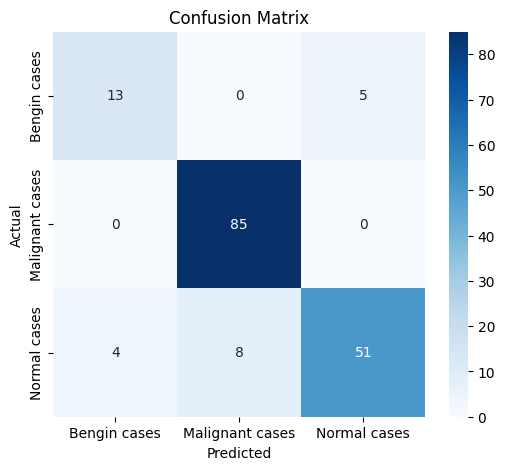

In [22]:
for name in single_model_names:
    print(f"\n===== Training {name.upper()} =====")

    model = get_single_model(name, num_classes=len(class_names)).to(device)

    model, history = train_model(
        model,
        train_loader,
        val_loader,
        device,
        epochs=EPOCHS,
    )

    test_acc, report, cm = test_model(
        model,
        test_loader,
        device,
        class_names,
    )

    results[name] = test_acc
    histories[name] = history

    print(f"\n{name} Test Accuracy: {test_acc:.4f}")
    print(report)

    plot_confusion_matrix(cm, class_names)

In [5]:
hybrid_configs = {
    # "resnet50_vit": lambda: get_hybrid_model("resnet50"),
    # "efficientnet_vit": lambda: get_hybrid_model("efficientnet_b0"),
    "multi_cnn_vit": lambda: get_multi_hybrid_model(
        cnn_list=("resnet50", "efficientnet_b0", "inception_v3")
    ),
}

EPOCHS = 20

for name, builder in hybrid_configs.items():
    print(f"\n===== Training {name.upper()} =====")

    model = builder().to(device)

    model, history = train_model(
        model,
        train_loader,
        val_loader,
        device,
        epochs=EPOCHS,
    )

    test_acc, report, cm = test_model(
        model,
        test_loader,
        device,
        class_names,
    )

    results[name] = test_acc
    histories[name] = history

    print(f"\n{name} Test Accuracy: {test_acc:.4f}")
    print(report)

    plot_confusion_matrix(cm, class_names)


===== Training MULTI_CNN_VIT =====


C:\Users\navne\anaconda3\envs\lung_gpu\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\navne\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\navne\anaconda3\envs\lung_gpu\lib\site-packages\huggingface_hub\file_download.py:130: UserWa


Epoch 1/20
Train Loss: 0.4637 | Train Acc: 0.8188
Val   Loss: 0.4029 | Val   Acc: 0.8537

Epoch 2/20
Train Loss: 0.2283 | Train Acc: 0.9153
Val   Loss: 0.2473 | Val   Acc: 0.9146

Epoch 3/20
Train Loss: 0.1373 | Train Acc: 0.9635
Val   Loss: 0.2725 | Val   Acc: 0.8902

Epoch 4/20
Train Loss: 0.1438 | Train Acc: 0.9465
Val   Loss: 0.2398 | Val   Acc: 0.9085

Epoch 5/20
Train Loss: 0.1000 | Train Acc: 0.9726
Val   Loss: 0.3019 | Val   Acc: 0.9024

Epoch 6/20
Train Loss: 0.0660 | Train Acc: 0.9844
Val   Loss: 0.2112 | Val   Acc: 0.9512

Epoch 7/20
Train Loss: 0.0770 | Train Acc: 0.9817
Val   Loss: 0.2612 | Val   Acc: 0.9268

Epoch 8/20
Train Loss: 0.0580 | Train Acc: 0.9844
Val   Loss: 0.0804 | Val   Acc: 0.9695

Epoch 9/20
Train Loss: 0.0464 | Train Acc: 0.9870
Val   Loss: 0.2029 | Val   Acc: 0.9634

Epoch 10/20
Train Loss: 0.0704 | Train Acc: 0.9778
Val   Loss: 0.1508 | Val   Acc: 0.9573

Epoch 11/20
Train Loss: 0.0435 | Train Acc: 0.9857
Val   Loss: 0.1782 | Val   Acc: 0.9695

Epoch 1

NameError: name 'results' is not defined

✅ Results saved → ./results/reports/results.csv


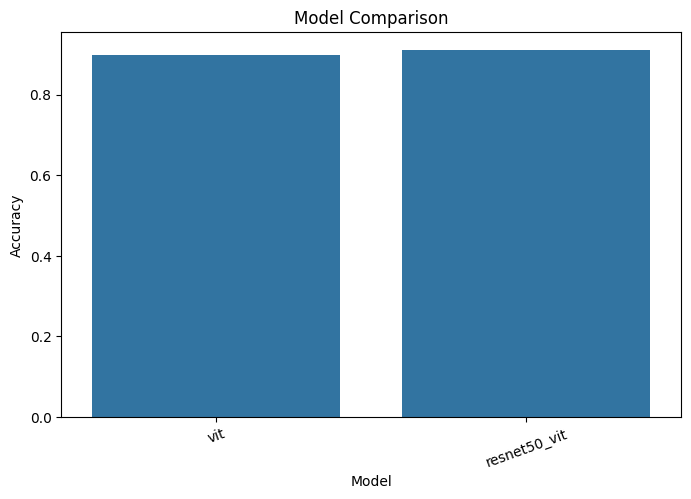

In [25]:
save_results_csv(results, "./results/reports/results.csv",preprocess_cfg,EPOCHS)
plot_model_comparison(results, "./results/plots/comparison.png")

Best model: resnet50_vit


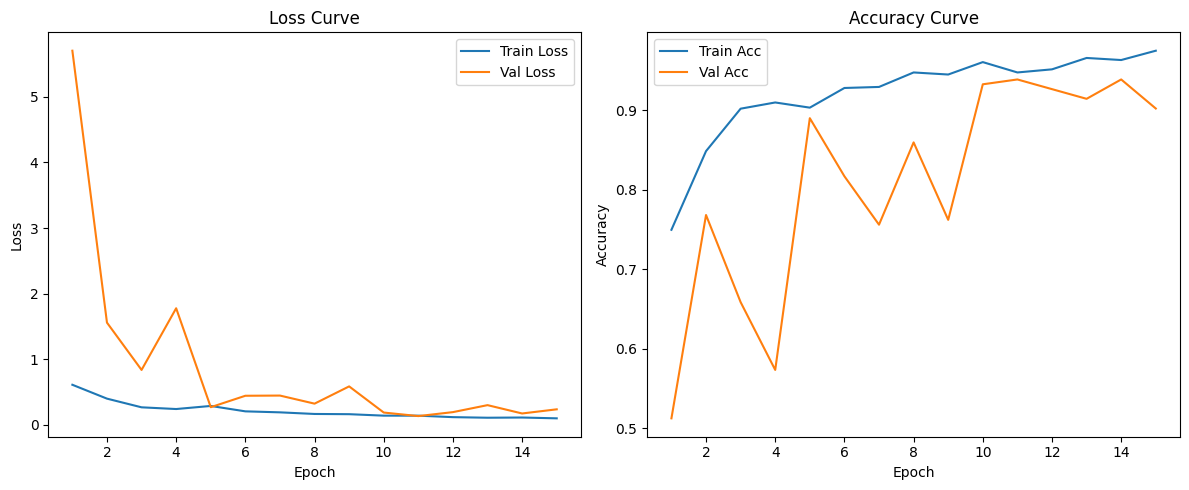

In [27]:
best_model_name = max(results, key=results.get)
print("Best model:", best_model_name)

plot_history(
    histories[best_model_name],
    f"./results/plots/{best_model_name}_history.png",
)